### Factoring Integers With Shor’s Algorithm

The most famous application of quantum computers is factoring integers using Shor’s algorithm. This algorithm is particularly significant because an efficient factorization algorithm could potentially break modern asymmetric encryption schemes, such as RSA.

For small integers, this quantum algorithm can be simulated on classical computers. The main challenge in classical implementation lies in the order-finding algorithm. We will first introduce the classical implementation of this algorithm as a preliminary step, and then proceed to explain the quantum order-finding algorithm.

In [1]:
!pip install contfrac==1.0.0 -q

/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
from math import gcd, log2, ceil
import numpy as np
import random
import cudaq
from cudaq import *
import fractions
import matplotlib.pyplot as plt
import contfrac

### Shor’s Algorithm

The factoring problem for an integer \( N \) aims to find integers \( p \) and \( q \) which are factors of \( N \). This problem is particularly interesting when \( N \) is not prime and the solutions \( p \) and \( q \) are non-trivial. In other words, we attempt to find integers \( p \) and \( q \) satisfying \( N = p \cdot q \) with \( 1 < p < N \) and \( 1 < q < N \).

The algorithm consists of two main ideas:

1. Reduce the problem of factoring the integer \( N \) to the order-finding problem.
2. Solve the order-finding problem: Given integers \( x \) and \( N \) such that \( x \) and \( N \) share no common factors (i.e., the greatest common divisor of \( x \) and \( N \) is 1), find the smallest positive integer \( r \) which satisfies \( x^r \equiv 1 \ (\text{mod} \ N) \). This value \( r \) is referred to as the order of \( x \).

These two ideas are combined in the following steps in Shor’s algorithm:

1. Rule out the easy case that \( N \) is even.
2. Select a random integer \( x \) between 1 and \( N-1 \).
3. Check to see if \( x \) is a factor of \( N \) (if so, we’re done!).
4. Find the order of \( x \) (i.e., find \( r \) such that \( x^r \equiv 1 \ (\text{mod} \ N) \)).
5. Check to see if \( \gcd(x^{r/2} - 1, N) \) or \( \gcd(x^{r/2} + 1, N) \) are integers and share common, non-trivial divisors with \( N \) (if so, we’re done!).
6. If no factor is found, repeat steps 1 through 5.

The function `shors_algorithm` below outlines these steps for both the classical and the quantum implementation of Shor’s algorithm. For demonstration purposes, we will also control the initial random integer selected in step 2 so that we can investigate cases in which the selected integer produces common divisors of \( N \) in step 5 and others in which step 5 produces no common factors.

**Note about terminology:** Some literature refers to the “period-finding problem” in Shor’s algorithm. The order-finding problem, as described above, can be recast as finding the period of the function \( f(x) = x^a \ (\text{mod} \ N) \), by noticing that the period of \( f \) is one more than the order of \( x \). The period-finding problem is more general than the order-finding problem since it aims to find the period of any periodic function, not just modular exponentiation.

In [3]:
def shors_algorithm(N, initial, quantum):
    """ Factor N using Shor's algorithm with initial starting value and choice of
    using either classical or quantum approach for the period finding step
    Parameters
    ----------
    N: int
        Integer to be factored (assumed to be non-prime and >1)
    initial: int
        Initial choice of the random integer between 2 and N-1
    quantum: boolean
        True if we will call the quantum order-finding algorithm, and false if we call the classical one for step 3.

    Returns
    -------
    a1, a2: int
        Non-trivial factors of N
    """

    # 0. Check to see if N is even.
    if N % 2 == 0:
        divisor1 = 2
        divisor2 = N // 2
        print("Found factors:", divisor1, divisor2)
        return (divisor1, divisor2)

    attempts = [initial]
    while (True):
        # 1. Select a random integer between 2 and N-1
        if len(attempts) == 1:
            a = initial
        else:
            a = random.choice(
                [n for n in range(N - 1) if n not in attempts and n != 1])

        # 2. See if the integer selected in step 1 happens to factor N
        print("Trying a =", a)
        divisor1 = gcd(a, N)
        if divisor1 != 1:
            divisor2 = N // divisor1
            print("Found factors of N={} by chance: {} and {}".format(
                N, divisor1, divisor2))
            return (divisor1, divisor2)

        # 3. Find the order of a mod N (i.e., r, where a^r = 1 (mod N))
        if quantum == True:
            r = find_order_quantum(a, N)
        else:
            r = find_order_classical(a, N)
        print("The order of a = {} is {}".format(a, r))

        # 4. If the order of a is found and it is
        # * even and
        # * not a^(r/2) = -1 (mod N),
        # then test a^(r/2)-1 and a^(r/2)+1 to see if they share factors with N.
        # We also want to rule out the case of finding the trivial factors: 1 and N.
        divisor1, divisor2 = test_order(a, r, N)
        if (divisor1 != 0):  # test_order will return a 0 if no factor is found
            print("Found factors of N = {}: {} and {}".format(
                N, divisor1, divisor2))
            return divisor1, divisor2

        # 5. Repeat
        print("retrying...")
        attempts.append(a)

Let’s first explore the idea of reducing the factoring problem into the order-finding problem. This gets captured in step 4 described above. In this step, we have already established that \(a\) and \(N\) share no factors other than 1 (i.e., \(\gcd(a, N) = 1\)) and we have found \(r\), the order of \(a\). With this information we know that \(a^r \equiv 1 \ (\text{mod} \ N)\). Rewritten in another way:

\[a^r - 1 \equiv 0 \ (\text{mod} \ N)\]

If \(r\) is even, we can rewrite \(a^r - 1\) as \((a^{r/2})^2 - 1\) where \(a^{r/2} \not\equiv -1 \ (\text{mod} \ N)\). Next, we can factor equation \(a^r - 1\) using the identity \(x^2 - y^2 = (x - y)(x + y)\):

\[(a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \ (\text{mod} \ N)\]

If, in addition, the equation

\[a^{r/2} \not\equiv -1 \ (\text{mod} \ N)\]

is satisfied, then at least one of the terms \(a^{r/2} - 1\) or \(a^{r/2} + 1\) must share a common factor with \(N\). Peter Shor demonstrated that there is greater than a 50% chance of randomly selecting a value for \(a\) satisfying these properties.

The code block below defines a function that tests whether \(r\) is even and whether equation \(a^{r/2} \not\equiv -1 \ (\text{mod} \ N)\) is satisfied and searches for a non-trivial factor of \(N\).

In [4]:
def test_order(a, r, N):
    """Checks whether or not a^(r/2)+1 or a^(r/2)-1 share a non-trivial common factor with N
    Parameters
    ----------
    a: int
    r: int
    N: int

    Returns
    -------
    int, int factors of N, if found; 0,0 otherwise
    """

    if r != None and (r % 2 == 0) and a**r % N == 1:
        if (a**(int(r / 2))) % N != -1:
            possible_factors = [gcd(r - 1, N), gcd(r + 1, N)]
            for test_factor in possible_factors:
                if test_factor != 1 and test_factor != N:
                    return test_factor, N // test_factor
    # period did not produce a factor
    else:
        print('No non-trivial factor found')
        return 0, 0

### Solving the Order-Finding Problem Classically

The key component of Shor’s algorithm is an efficient quantum algorithm to find the order of \(a\). While a straightforward classical algorithm can solve this problem, it is notably inefficient:

In [5]:
def find_order_classical(a, N):
    """A naive classical method to find the order r of a (mod N).
    Parameters
    ----------
    a: int
        an integer in the interval [2,N-1]
    N: int

    Returns
    -------
    r: int
        Period of a^x (mod N)
    """
    assert 1 < a and a < N
    r = 1
    y = a
    while y != 1:
        y = y * a % N
        r += 1
    return r

Let’s see how Shor’s algorithm works on a few examples using the classical order-finding problem. Notice how often our choice of value for the initial guess for \(a\) produces factors of \(N\).

In [8]:
my_integer = 1349  #edit this value to try out a few examples
# Edit the value in the line below to try out different initial guesses for a.
# What happens when you choose a = 42 for the integer 123?
# What happens when you choose a = 100 for the integer 123?
initial_value_to_start = 100  # edit this value; it should be less than my_integer

shors_algorithm(my_integer, initial_value_to_start, False)

Trying a = 100
The order of a = 100 is 315
No non-trivial factor found
retrying...
Trying a = 645
The order of a = 645 is 70
Found factors of N = 1349: 71 and 19


(71, 19)

### Solving the Order-Finding Problem with a Quantum Algorithm

The Fourier transform is a classical computation that provides a more efficient algorithm than the one encoded in `find_order_classical` for identifying the period of \(a\). The quantum version of the Fourier transform is the central idea of Shor’s Algorithm. This efficient quantum solution derives the period from a measurement of \(n\) qubits.

The image below outlines the quantum kernel used to find the order of \(a\). Notice the last step involves applying the Inverse Quantum Fourier Transform.



*Figure: Circuit diagram for finding the phase of the modular multiplication gate \(U|x\rangle = |a^x \mod N\rangle\), which will be used to compute the order of \(a\) modulo \(N\). The number of qubits in the control register determines the accuracy of estimating the phase of \(a\). The size of the work register depends on \(N\). The goal of this section is to code the diagram as a kernel named `phase_kernel`.*

We will need to create a quantum kernel for the Inverse Quantum Fourier Transform. Additionally, we’ll need to create a kernel for modular multiplication: \(U|x\rangle = |a^x \mod N\rangle\), which can be repeatedly applied \(r\)-times to \(a\) to carry out modular exponentiation \(a^r \mod N\).

### Inverse Quantum Fourier Transform

In the code block below, we define a kernel for the quantum Fourier transform and then use `cudaq.adjoint` to create a kernel for the inverse quantum Fourier transform used in the quantum order-finding algorithm.

```python
def qft(qubits):
    """Quantum Fourier Transform on the given qubits."""
    n = len(qubits)
    for i in range(n):
        for j in range(i):
            cudaq.cp(qubits[j], qubits[i], np.pi / 2**(i-j))
        cudaq.h(qubits[i])

# Create the inverse Quantum Fourier Transform kernel
iqft = cudaq.adjoint(qft)
```

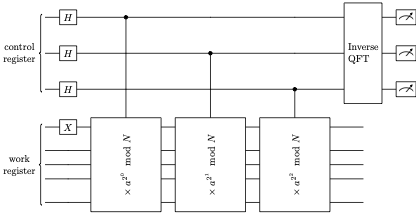

In [9]:
# Define kernels for the quantum Fourier transform and the inverse quantum Fourier transform
@cudaq.kernel
def quantum_fourier_transform(qubits: cudaq.qview):
    qubit_count = len(qubits)
    # Apply Hadamard gates and controlled rotation gates.
    for i in range(qubit_count):
        h(qubits[i])
        for j in range(i + 1, qubit_count):
            angle = (2 * np.pi) / (2**(j - i + 1))
            cr1(angle, [qubits[j]], qubits[i])


@cudaq.kernel
def inverse_qft(qubits: cudaq.qview):
    cudaq.adjoint(quantum_fourier_transform, qubits)

### Quantum Kernels for Modular Exponentiation

While Shor’s algorithm provably can factor numbers faster than known classical techniques, the resources required for implementing Shor’s algorithm are hefty. A full-scale implementation to factor an \( n \)-bit number could require a quantum kernel with \( 2n + 3 \) qubits to achieve accuracy for the continued fractions part of the algorithm and as many as \( 72n^3 \) quantum gates for the modular exponentiation (Beckman, Chari, Devabhaktuni, & Preskill, 1996). Both of these are well beyond the capabilities of modern quantum hardware for numbers of interest. Advancements to reduce the number of gates and qubits required focus on optimizing the kernel for \( a \) for properties of the number to be factored. The difficulty is to create efficient quantum kernels (in terms of qubit and gate count) that compute \( a^x \mod N \).

For the purposes of this demonstration, we will consider only the order-finding problem for the values of \( N \) to be either \( 15 \) or \( 21 \) with \( a = 4 \). We’ll be using the quantum circuits depicted in this [paper](https://arxiv.org/abs/quant-ph/9602016) and this [report](https://arxiv.org/abs/quant-ph/9503016), respectively.

#### The Case \( N = 21 \) and \( a = 5 \)

In [10]:
@cudaq.kernel
def modular_mult_5_21(work: cudaq.qview):
    """"Kernel for multiplying by 5 mod 21
    based off of the circuit diagram in
    https://physlab.org/wp-content/uploads/2023/05/Shor_s_Algorithm_23100113_Fin.pdf
    Modifications were made to change the ordering of the qubits"""
    x(work[0])
    x(work[2])
    x(work[4])

    swap(work[0], work[4])
    swap(work[0], work[2])


@cudaq.kernel
def modular_exp_5_21(exponent: cudaq.qview, work: cudaq.qview,
                     control_size: int):
    """ Controlled modular exponentiation kernel used in Shor's algorithm
    |x> U^x |y> = |x> |(5^x)y mod 21>
    """
    x(work[0])
    for exp in range(control_size):
        ctrl_qubit = exponent[exp]
        for _ in range(2**(exp)):
            cudaq.control(modular_mult_5_21, ctrl_qubit, work)

In [11]:
# Demonstrate iterated application of 5y mod 21 where y = 1
@cudaq.kernel
def demonstrate_mod_exponentiation(iterations: int):
    qubits = cudaq.qvector(5)
    x(qubits[0]
     )  # initalizes the qubits in the state for y = 1 which is |10000>
    for _ in range(iterations):
        modular_mult_5_21(qubits)


shots = 200

# The iterations variable determines the exponent in 5^x mod 21.
# Change this value to verify that the demonstrate_mod_exponentiation
# kernel carries out the desired calculation.
iterations = 1

print(cudaq.draw(demonstrate_mod_exponentiation, iterations))

results = cudaq.sample(demonstrate_mod_exponentiation,
                       iterations,
                       shots_count=shots)

print("Measurement results from sampling:", results)

# Reverse the order of the most probable measured bit string
# and convert the binary string to an integer
integer_result = int(results.most_probable()[::-1], 2)

print("For x = {}, 5^x mod 21 = {}".format(iterations, (5**iterations) % 21))
print("For x = {}, the computed result of the circuit is {}".format(
    iterations, integer_result))

     ╭───╮╭───╮      
q0 : ┤ x ├┤ x ├─╳──╳─
     ╰───╯╰───╯ │  │ 
q1 : ───────────┼──┼─
     ╭───╮      │  │ 
q2 : ┤ x ├──────┼──╳─
     ╰───╯      │    
q3 : ───────────┼────
     ╭───╮      │    
q4 : ┤ x ├──────╳────
     ╰───╯           

Measurement results from sampling: { 10100:200 }

For x = 1, 5^x mod 21 = 5
For x = 1, the computed result of the circuit is 5


#### The Case \( N = 21 \) and \( a = 4 \)

The example below demonstrates an optimized work register that uses fewer gates and qubits compared to a straightforward implementation of modular multiplication, as seen in the previous case.

In [15]:
@cudaq.kernel
def modular_exp_4_21(exponent: cudaq.qview, work: cudaq.qview):
    """ Controlled modular exponentiation kernel used in Shor's algorithm
     |x> U^x |y> = |x> |(4^x)y mod 21>
     based off of the circuit diagram in https://arxiv.org/abs/2103.13855
     Modifications were made to account for qubit ordering differences"""
    swap(exponent[0], exponent[2])
    # x = 1
    x.ctrl(exponent[2], work[1])

    # x = 2
    x.ctrl(exponent[1], work[1])
    x.ctrl(work[1], work[0])
    x.ctrl([exponent[1], work[0]], work[1])
    x.ctrl(work[1], work[0])

    # x = 4
    x(work[1])
    x.ctrl([exponent[0], work[1]], work[0])
    x(work[1])
    x.ctrl(work[1], work[0])
    x.ctrl([exponent[0], work[0]], work[1])
    x.ctrl(work[1], work[0])
    swap(exponent[0], exponent[2])

In [16]:
@cudaq.kernel
def phase_kernel(control_register_size: int, work_register_size: int, a: int,
                 N: int):
    """
    Kernel to estimate the phase of the modular multiplication gate |x> U |y> = |x> |a*y mod 21> for a = 4 or 5
    """

    qubits = cudaq.qvector(control_register_size + work_register_size)
    control_register = qubits[0:control_register_size]
    work_register = qubits[control_register_size:control_register_size +
                           work_register_size]

    h(control_register)

    if a == 4 and N == 21:
        modular_exp_4_21(control_register, work_register)
    if a == 5 and N == 21:
        modular_exp_5_21(control_register, work_register, control_register_size)

    inverse_qft(control_register)

    # Measure only the control_register and not the work_register
    mz(control_register)

In [ ]:
control_register_size = 3
work_register_size = 5
values_for_a = [4, 5]
idx = 1  # changing to 1  selects 5
N = 21
shots = 15000

print(
    cudaq.draw(phase_kernel, control_register_size, work_register_size,
               values_for_a[idx], N))

results = cudaq.sample(phase_kernel,
                       control_register_size,
                       work_register_size,
                       values_for_a[idx],
                       N,
                       shots_count=shots)
print(
    "Measurement results for a={} and N={} with {} qubits in the control register "
    .format(values_for_a[idx], N, control_register_size))
print(results)

     ╭───╮                                                                    »
q0 : ┤ h ├──●────●────●───●──●────────────────────────────────────────────────»
     ├───┤  │    │    │   │  │                                                »
q1 : ┤ h ├──┼────┼────┼───┼──┼───●────●────●───●──●───●────●────●───●──●──────»
     ├───┤  │    │    │   │  │   │    │    │   │  │   │    │    │   │  │      »
q2 : ┤ h ├──┼────┼────┼───┼──┼───┼────┼────┼───┼──┼───┼────┼────┼───┼──┼───●──»
     ├───┤╭─┴─╮  │    │   │  │ ╭─┴─╮  │    │   │  │ ╭─┴─╮  │    │   │  │ ╭─┴─╮»
q3 : ┤ x ├┤ x ├──┼────┼───╳──╳─┤ x ├──┼────┼───╳──╳─┤ x ├──┼────┼───╳──╳─┤ x ├»
     ╰───╯╰───╯  │    │   │  │ ╰───╯  │    │   │  │ ╰───╯  │    │   │  │ ╰───╯»
q4 : ────────────┼────┼───┼──┼────────┼────┼───┼──┼────────┼────┼───┼──┼──────»
               ╭─┴─╮  │   │  │      ╭─┴─╮  │   │  │      ╭─┴─╮  │   │  │      »
q5 : ──────────┤ x ├──┼───┼──╳──────┤ x ├──┼───┼──╳──────┤ x ├──┼───┼──╳──────»
               ╰───╯  │   │         ╰───